We will use a Runge-Kutta 4th order fixed time step method modified to include random noise (RK4) to solve various arrangements of Josephson junctions on the way to an application to modelling the superconducting quantum interference device (SQUID). To model noise, we will need to supply the correct noise values to the solver over the next time interval. The RK4 method will use half-time steps, meaning the method will calculate values at the current moment, halfway to the next time output, and at the next time point to output the value at the next time point. At the first iteration, the method will use $t_0, t_{1/2}, t_1$ to output $v_1$. Then, it will use $t_1, t_{3/2}, t_2$ to output $v_2$. Then we need to keep track of and pass noise values $v_n$ such that the RK4 method has available $v_0, v_1, v_2$ at $t_0$ to return $v_1$ and then pass $v_2, v_3, v_4$ at $t_1$ to return $v_2$, and so on.

To test the numerical technique including resistive noise across the junction, we will start with a single noisy Josephson junction. The model is described by the first order differential equations

$$v=i-\sin{\delta} +v_N$$
$$d\delta/d\theta=v$$

where $v_N$ is the Johnson noise voltage across the shunt resistance, with $\langle v_N^2\rangle = 2\Gamma / \Delta\theta$. However, because we choose to use a Runge-Kutta 4th order fixed step size solver modified to accept noise, we need twice as many noise values as actual time steps we are solving for. Thus, we use

$$\sigma_{v_N}^2 = \frac{2\Gamma}{\frac{\Delta \theta}{2}} = \frac{4\Gamma}{\Delta \theta}$$
$$\sigma_{v_N} = \sqrt{\frac{4\Gamma}{\Delta \theta}}$$

in a Gaussian distributed random number generator to generate $2n+1$ noise values.

The parameter $\Gamma$ is a reference to the Johnson noise, and is temperature dependent. We will pass $\Gamma$ as a numerical value, not derived.

$v$ - voltage across junction

$i$ - bias current accross junction

$\theta$ - time

$\delta$ - phase difference accross junction

$v_N$ - noise voltage accross shunt resistance

$\Gamma$ - temperature dependent noise parameter

We will need a few parameters in addition to these to run the model:

$nStep$ - number of time steps for which to give output

$\tau$ - the size of the time step, $\Delta \theta$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft
import scipy.signal as sig

In [2]:
def noisyrk4(s,t,tau,derivsRK,i,vN0,vN1,vN2):
    
#   Runge-Kutta integrator 4th order
# INputs
#   x           -   current values of dependent variable
#   t           -   independent variable usually time
#   tau         -   step size usually time step
#   derivsRK    -   RHS of the ODE, fn defined somewhere
#   param       -   extra parameters passed to deriv fn
# Output
#   xout        -   new value of dependent variable after a step size tau

    half_tau = 0.5*tau
    
    F1 = derivsRK(s,t,i,vN0)                    # use current voltage noise
    t_half = t + half_tau
    stemp = s + half_tau*F1
    
    F2 = derivsRK(stemp,t_half,i,vN1)           # use half-tau step voltage noise
    stemp = s + half_tau*F2
    
    F3 = derivsRK(stemp,t_half,i,vN1)           # use half-tau step voltage noise
    t_full = t + tau
    stemp = s + tau*F3
    
    F4 = derivsRK(stemp,t_full,i,vN2)           # use full-tau step voltage noise
    sout = s + tau/6.*(F1 + F4 + 2.*(F2 + F3))
    return sout   

In [3]:
def snJJRK2(s,t,i,vN):
    
#    Returns RHS of single junction with noise RSJ ODE; used by rk4
# Inputs
#    s      -   State vector [del(theta)]
#    param -   [i, vN]
# Ouputs
#    deriv  -   Derivaties [d(theta)]
#    vN     -   noise voltage generaterd, for logging

    deriv = i - np.sin(s) + vN                  # d(del)/dtheta = v = i - sin(del) + vN
    return(deriv)

In [4]:
# Inputs
#                0    1
#     param = [i, Gamma]
#     s = [del_0] phase difference
#     tau = time step size# Inputs
#                0    1
#     XXparam = [i, Gamma]XX
#     s = [del_0] phase difference
#     tau = time step size
#     nStep = number of points
# Output
#           0     1  2 3  
#     X = [theta,del,v,vN]

def snJJ2(nStep,tau,s,i,Gamma):
    var = 4*Gamma/tau                                   # var = 2*Gamma/tau
    sd = var**.5                                        # std dev = var^.5, for gaussian noise
    theta = 0                                           # set time theta to zero
    vN = np.zeros(2*nStep+1)                            # crate holder for noise values
    for N in range(2*nStep+1): 
        vN[N] = np.random.normal(0,sd)                  # fill noise values, two for each tau
    X = np.zeros([3,nStep])                             # create output array
    
    X[0,0] = theta                                      # record initial time theta
    X[1,0] = s                                          # record initial del, phase diff
    X[2,0] = i - np.sin(s) + vN[0]                      # record initial voltage
    
    for iStep in range(1,nStep):                        # for loop through time
        vN0 = vN[2*iStep-2]  
        vN1 = vN[2*iStep-1]                               
        vN2 = vN[2*iStep]                               # read off noise values to use

        s = noisyrk4(s,theta,tau,snJJRK2,i,vN0,vN1,vN2) # call rk4 with snJJRK to get next state value
        
        X[0,iStep] = theta                              ##  theta  ##   record time theta to output array
        X[1,iStep] = s                                  ##  delta  ##   record state, phase diff
        X[2,iStep] = i - np.sin(s) + vN2                ## voltage ##   record v, i - sin(delta) + vn
        theta = theta + tau                             # advance time for start of next cycle
        
    return(vN[0:-1:2],X)                                # return every other noise voltage value

In [5]:
# parameters for a single junction
s = 120             # s - state, initial phase
nStep = int(1e6)    #80000000 #80000 # nStep - how long to run. 8e7 is long
tau = 0.1           # tau - time step size, in dimensionless theta
i = 1.25            # i - bias current, in multiples of critical current
Gamma = 0.05        # Gamma

In [8]:
%%time
vN,N1 = snJJ2(nStep,tau,s,i,Gamma)

Wall time: 15.5 s


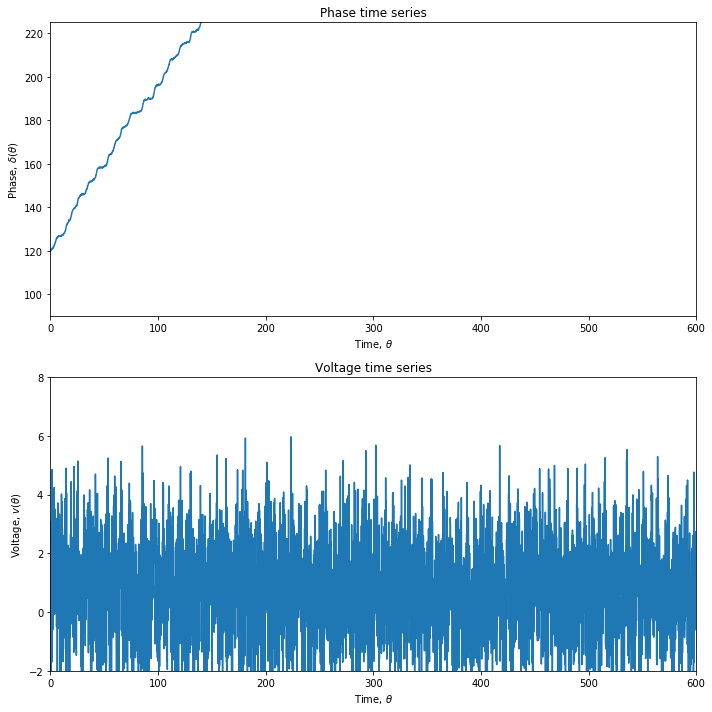

In [9]:
e = int(np.where(N1[0,] >= 600)[0][[0]]) # find theta = 600

fig,ax = plt.subplots(2,1,figsize=[10,10])
ax1 = plt.subplot(2,1,1)
ax1.plot(N1[0,:e],N1[1,:e])
ax1.set(title=r'Phase time series',
       xlabel=r'Time, $\theta$',
       ylabel=r'Phase, $\delta(\theta)$',
       xlim=[0,N1[0,e]], # xlim=[0,nStep*tau],
       ylim=[90,225])
       
ax2 = plt.subplot(2,1,2)
ax2.plot(N1[0,:e],N1[2,:e])
ax2.set(title=r'Voltage time series',
       xlabel=r'Time, $\theta$',
       ylabel=r'Voltage, $v(\theta)$',
       xlim=[0,N1[0,e]],
       ylim=[-2,8])
fig.tight_layout()

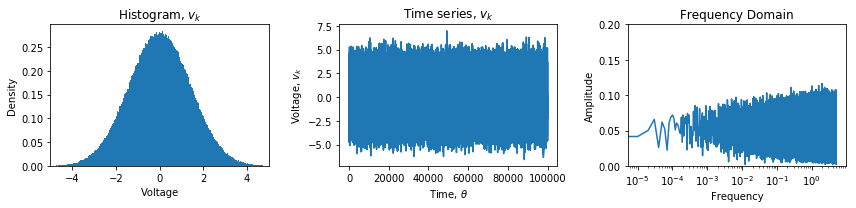

In [47]:
n = nStep
#frq = np.arange(n)*tau/n
frq = np.fft.fftfreq(nStep, tau)
frq = frq[:n//2]
vNtilda = fft.fft(vN)/n
vNtilda = vNtilda[:n//2]

fig,ax = plt.subplots(1,3,figsize=[12,3])
ax1 = plt.subplot(1,3,1)
ax1.hist(vN,bins='auto',density=True)
ax1.set(title=r'Histogram, $v_k$',
       xlabel='Voltage',
       ylabel='Density',
       xlim = [-5,5])
ax2 = plt.subplot(1,3,2)
ax2.plot(np.arange(n)*tau,vN)
ax2.set(title=r'Time series, $v_k$',
       xlabel=r'Time, $\theta$',
       ylabel=r'Voltage, $v_k$')
ax3 = plt.subplot(1,3,3)
ax3.semilogx(frq,(np.abs(vNtilda)/(2*Gamma))**.5)
ax3.set(title='Frequency Domain',
       xlabel=r'Frequency',
       ylabel=r'Amplitude',
       ylim=[0,.2])
fig.tight_layout()

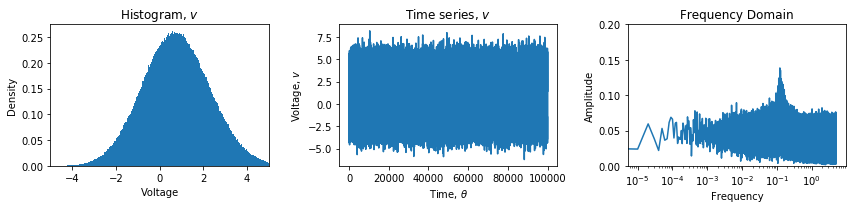

In [46]:
v = np.copy(N1[2,])
n = len(v)
frq = np.fft.fftfreq(nStep, tau)
#frq = np.arange(n)*tau/n
frq = frq[:n//2]
vtilda = fft.fft(v)/n
vtilda = vtilda[:n//2]

fig,ax = plt.subplots(1,3,figsize=[12,3])
ax1 = plt.subplot(1,3,1)
ax1.hist(v,bins='auto',density=True)
ax1.set(title=r'Histogram, $v$',
       xlabel='Voltage',
       ylabel='Density',
       xlim = [-5,5])
ax2 = plt.subplot(1,3,2)
ax2.plot(np.arange(n)*tau,v)
ax2.set(title=r'Time series, $v$',
       xlabel=r'Time, $\theta$',
       ylabel=r'Voltage, $v$')
ax3 = plt.subplot(1,3,3)
ax3.semilogx(frq,(np.abs(vtilda)/(4*Gamma))**.5)
ax3.set(title='Frequency Domain',
       xlabel=r'Frequency',
       ylabel=r'Amplitude',
       ylim=[0,.2])
fig.tight_layout()

In [12]:
sum(N1[2,])/len(N1[2,])

0.763090734089548

In [12]:
za = int(np.where(frq >= 2e-4)[0][[0]])
zb = int(np.where(frq >= 2e-3)[0][[0]])
sum((np.abs(vtilda[za:zb])/(4*Gamma))**.5)/((zb-za))

0.09180889235165436

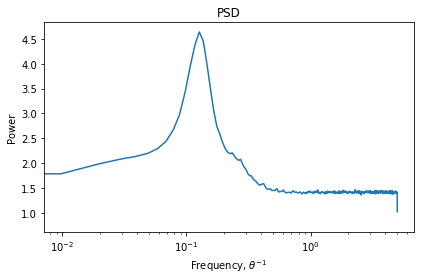

In [13]:
frqz, psd = sig.welch(v,1/tau,return_onesided=True, nperseg=1024, )
fig, ax = plt.subplots(1,1)
ax.semilogx(frqz, (psd/4/Gamma)**.5)
ax.set(title='PSD',
       xlabel=r'Frequency, $\theta^{-1}$',
       ylabel=r'Power')
fig.tight_layout()

In [14]:
(psd[0]/4/Gamma)**.5

0.8036281937937081

In [15]:
(psd[1]/4/Gamma)**.5

1.786584748117648

In [31]:
%%time
Gamma = 0.05
ia = np.arange(.25,1.75,.1)
X2 = np.zeros([len(ia),3])
for i in range(len(ia)):
    m,M = snJJ2(nStep,tau,s,ia[i],Gamma)
    X2[i,0] = ia[i]                     # applied current
    X2[i,1] = sum(M[2,])/len(M[2,])     # average voltage
    frq, psd = sig.welch(M[2,], 1/tau, return_onesided=True, nperseg=1024)
    X2[i,2] = (psd[1]/4/Gamma)**.5      # low-frequency noise value

Wall time: 3min 32s


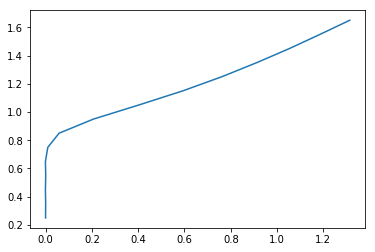

In [32]:
plt.plot(X2[:,1], X2[:,0])

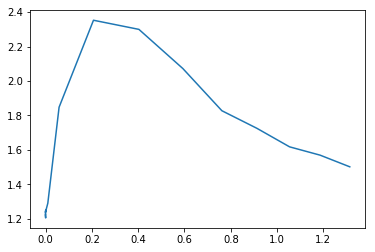

In [33]:
plt.plot(X2[:,1], X2[:,2])

In [34]:
%%time
Gamma = 0.1
ia = np.arange(.25,1.75,.1)
X3 = np.zeros([len(ia),3])
for i in range(len(ia)):
    m,M = snJJ2(nStep,tau,s,ia[i],Gamma)
    X3[i,0] = ia[i]                     # applied current
    X3[i,1] = sum(M[2,])/len(M[2,])     # average voltage
    frq, psd = sig.welch(M[2,], 1/tau, return_onesided=True, nperseg=1024)
    X3[i,2] = (psd[1]/4/Gamma)**.5      # low-frequency noise value

Wall time: 3min 34s


In [35]:
%%time
Gamma = 0.2
ia = np.arange(.25,1.75,.1)
X4 = np.zeros([len(ia),3])
for i in range(len(ia)):
    m,M = snJJ2(nStep,tau,s,ia[i],Gamma)
    X4[i,0] = ia[i]                     # applied current
    X4[i,1] = sum(M[2,])/len(M[2,])     # average voltage
    frq, psd = sig.welch(M[2,], 1/tau, return_onesided=True, nperseg=1024)
    X4[i,2] = (psd[1]/4/Gamma)**.5      # low-frequency noise value

Wall time: 3min 45s


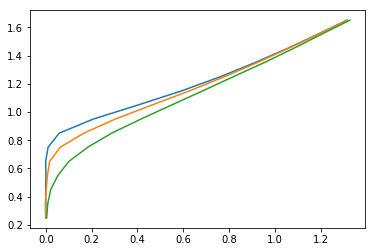

In [36]:
plt.plot(X2[:,1],X2[:,0],
         X3[:,1],X3[:,0],
         X4[:,1],X4[:,0])

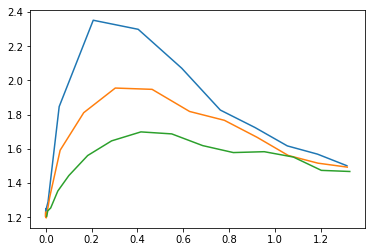

In [43]:
plt.plot(X2[:,1],X2[:,2],
         X3[:,1],X3[:,2],
         X4[:,1],X4[:,2])

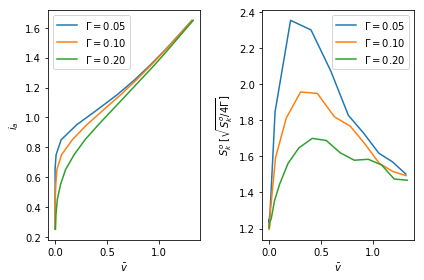

In [56]:
fig, ax = plt.subplots(1,2, figsize=[6,4])
ax1 = plt.subplot(1,2,1)
ax1.plot(X2[:,1],X2[:,0],label=r'$\Gamma = 0.05$')
ax1.plot(X3[:,1],X3[:,0],label=r'$\Gamma = 0.10$')
ax1.plot(X4[:,1],X4[:,0],label=r'$\Gamma = 0.20$')
ax1.set(xlabel = r'$\bar{v}$',
       ylabel = r'$i_a$')
ax1.legend()
ax2 = plt.subplot(1,2,2)
ax2.plot(X2[:,1],X2[:,2],label=r'$\Gamma = 0.05$')
ax2.plot(X3[:,1],X3[:,2],label=r'$\Gamma = 0.10$')
ax2.plot(X4[:,1],X4[:,2],label=r'$\Gamma = 0.20$')
ax2.set(xlabel = r'$\bar{v}$',
       ylabel = r'$S_k^o$ [$\sqrt{S_k^o/4\Gamma}$]')
ax2.legend()
fig.tight_layout()